# CNN Model building from scratch

### Importing required libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import Precision, Recall, Accuracy
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score,log_loss
from tabulate import tabulate
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

### Declaring the Variables

In [3]:
IMAGE_SIZE = [299,299]
BATCH_SIZE=16
FOLDS=10
SCORES_PER_FOLD=[]
CLASSES=["60-40","70-30","80-20","90-10"]

In [4]:
training_image_dir='/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/001_Dataset_Turmeric/Training'
testing_image_dir='/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/001_Dataset_Turmeric/Testing'
validation_image_dir='/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/001_Dataset_Turmeric/Validation'

### Fetching and Preprocessing the image files

In [5]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [6]:
training_image_data_set =tf.keras.utils.image_dataset_from_directory(
  training_image_dir,
  label_mode='int',
  seed=131,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE
)

Found 3108 files belonging to 4 classes.


In [7]:
validation_image_data_set=tf.keras.utils.image_dataset_from_directory(
    validation_image_dir,
    label_mode='int',
    seed=131,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 1264 files belonging to 4 classes.


In [8]:
testing_image_data_set=tf.keras.utils.image_dataset_from_directory(
    testing_image_dir,
    label_mode='int',
    seed=131,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 1325 files belonging to 4 classes.


In [9]:
print(f'Using {len(training_image_data_set)} sets for Training')
print(f'Using {len(validation_image_data_set)} sets for Validation')
print(f'Using {len(testing_image_data_set)} sets for Testing')

Using 195 sets for Training
Using 79 sets for Validation
Using 83 sets for Testing


In [10]:
normalized_training_set=training_image_data_set.map(lambda x,y: (normalization_layer(x), y))
normalized_validation_set=validation_image_data_set.map(lambda x,y: (normalization_layer(x), y))
normalized_testing_set=testing_image_data_set.map(lambda x,y: (normalization_layer(x), y))

# image_batch, labels_batch = next(iter(normalized_training_set))      #<-----the data is fethched in this form: image batch, label batch

### Building the CNN Model

In [11]:
def Build_Model():
  model=Sequential()

  model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(299,299,3)))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(64, (3,3), 1, activation='relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(64, (3,3), 1, activation='relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(128, (3,3), 1, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())

  model.add(Dense(256, activation='relu'))
  model.add(Dense(4, activation='sigmoid'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [12]:
# Summary of the model
model=Build_Model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 148, 148, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 64)        0

### Peforming the 10 Fold Cross Validation

In [13]:
logdir='/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/003_Logs/10FOLDCROSSVALIDATED_Model_Logs'

In [14]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [15]:
model_dir='/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/004_Cross_Validated_Models/'

In [16]:
TFold_start=time.time()

In [17]:
i=0
j=19
k=171
for fold_var in range(0,FOLDS,1):
  print(f'Fold {fold_var+1}')
  print('--------------------------------------------------------------------------------------------')
  training_set1=normalized_training_set.take(i)
  training_set2=normalized_training_set.skip(i+j).take(k)
  training_set=training_set1.concatenate(training_set2)
  validation_set=normalized_training_set.skip(i).take(j)
  i=i+19
  j=19
  k=k-19

  model=Build_Model()
  Model_Run = model.fit(
    training_set,
    epochs=20,
    steps_per_epoch=len(training_set),
    callbacks=[tensorboard_callback]
  )
  print('\n')
  print(f'Evaluating the model')
  print('\n')
  cur_scores=model.evaluate(validation_set)
  cur_scores[0]*=100
  cur_scores[1]*=100
  cur_scores=[fold_var+1,cur_scores[0],cur_scores[1]]
  SCORES_PER_FOLD.append(cur_scores)

  model.save(model_dir+'model_'+str(fold_var+1)+'.h5')
  print('--------------------------------------------------------------------------------------------')
  tf.keras.backend.clear_session()

Fold 1
--------------------------------------------------------------------------------------------
Epoch 1/20
171/171 [==============================] - 540s 3s/step - loss: 0.6215 - accuracy: 0.6787
Epoch 2/20
171/171 [==============================] - 9s 49ms/step - loss: 0.4106 - accuracy: 0.7840
Epoch 3/20
171/171 [==============================] - 9s 45ms/step - loss: 0.3701 - accuracy: 0.8070
Epoch 4/20
171/171 [==============================] - 10s 53ms/step - loss: 0.4321 - accuracy: 0.8249
Epoch 5/20
171/171 [==============================] - 8s 43ms/step - loss: 0.3615 - accuracy: 0.8238
Epoch 6/20
171/171 [==============================] - 9s 48ms/step - loss: 0.3655 - accuracy: 0.8227
Epoch 7/20
171/171 [==============================] - 9s 48ms/step - loss: 0.3385 - accuracy: 0.8121
Epoch 8/20
171/171 [==============================] - 9s 46ms/step - loss: 0.2885 - accuracy: 0.8618
Epoch 9/20
171/171 [==============================] - 11s 55ms/step - loss: 0.3418 - accura

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


--------------------------------------------------------------------------------------------
Fold 2
--------------------------------------------------------------------------------------------
Epoch 1/20
171/171 [==============================] - 11s 51ms/step - loss: 0.6912 - accuracy: 0.6338
Epoch 2/20
171/171 [==============================] - 10s 53ms/step - loss: 0.4361 - accuracy: 0.7632
Epoch 3/20
171/171 [==============================] - 10s 57ms/step - loss: 0.5153 - accuracy: 0.7657
Epoch 4/20
171/171 [==============================] - 8s 48ms/step - loss: 0.4908 - accuracy: 0.7613
Epoch 5/20
171/171 [==============================] - 10s 58ms/step - loss: 0.3532 - accuracy: 0.7986
Epoch 6/20
171/171 [==============================] - 10s 54ms/step - loss: 0.6548 - accuracy: 0.7460
Epoch 7/20
171/171 [==============================] - 9s 50ms/step - loss: 0.3695 - accuracy: 0.8052
Epoch 8/20
171/171 [==============================] - 11s 61ms/step - loss: 0.2972 - accuracy: 

In [18]:
TFold_stop=time.time()

In [19]:
print(f'Time required for 10 Fold Cross Validation= {TFold_stop-TFold_start} seconds')

Time required for 10 Fold Cross Validation= 3416.197620868683 seconds


In [20]:
column_headers=['Fold Number','Validation Loss(%)','Validation Accuracy(%)']
print('10 Fold Cross Validation Result')
print(tabulate(SCORES_PER_FOLD, headers=column_headers, tablefmt="grid"))

10 Fold Cross Validation Result
+---------------+----------------------+--------------------------+
|   Fold Number |   Validation Loss(%) |   Validation Accuracy(%) |
+===============+======================+==========================+
|             1 |             27.0722  |                  92.4342 |
+---------------+----------------------+--------------------------+
|             2 |             23.8493  |                  87.5    |
+---------------+----------------------+--------------------------+
|             3 |              9.29193 |                  97.0395 |
+---------------+----------------------+--------------------------+
|             4 |              8.64249 |                  97.6974 |
+---------------+----------------------+--------------------------+
|             5 |              9.13816 |                  97.0395 |
+---------------+----------------------+--------------------------+
|             6 |            138.044   |                  27.6316 |
+---------------

### Selecting the model with highest accuracy for training

In [21]:
max_acc=SCORES_PER_FOLD[0][2]
max_acc_index=[]
for i in range(len(SCORES_PER_FOLD)):
  if(SCORES_PER_FOLD[i][2]>max_acc):
    max_acc=SCORES_PER_FOLD[i][2]
print(f'The maximum validation accuracy is: {max_acc}')
for i in range(len(SCORES_PER_FOLD)):
  if(SCORES_PER_FOLD[i][2]==max_acc):
    max_acc_index.append(i)
print(f'The folds having {max_acc} validation accuracy are:')
for i in range(len(max_acc_index)):
  print(max_acc_index[i]+1)

result=-1
if(len(max_acc_index)>1):
    min_loss=SCORES_PER_FOLD[max_acc_index[0]][1]
    j=0
    result=max_acc_index[0]
    while(j<len(max_acc_index)):
      index=max_acc_index[j]
      if(SCORES_PER_FOLD[index][1]<min_loss):
        min_loss=SCORES_PER_FOLD[index][1]
        result=index
      j+=1
else:
  result=max_acc_index[0]
print(f'Selecting the model of fold no {result+1} for fine parameter tuning')
model=load_model(model_dir+'model_'+str(result+1)+'.h5')

The maximum validation accuracy is: 97.69737124443054
The folds having 97.69737124443054 validation accuracy are:
4
Selecting the model of fold no 4 for fine parameter tuning


### Training the model for fine parameter tuning

In [22]:
scratch_model_logdir='/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/003_Logs/SCRATCH_MODEL_Logs'

In [23]:
scratch_model_tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=scratch_model_logdir)

In [26]:
Training_start=time.time()

In [27]:
Cur_Model_Run = model.fit(
    normalized_training_set,
    validation_data=normalized_validation_set,
    epochs=30,
    validation_steps=len(normalized_validation_set),
    callbacks=[scratch_model_tensorboard_callback]
  )

Epoch 1/30
195/195 [==============================] - 14s 69ms/step - loss: 0.1332 - accuracy: 0.9469 - val_loss: 0.0938 - val_accuracy: 0.9684
Epoch 2/30
195/195 [==============================] - 12s 62ms/step - loss: 0.1204 - accuracy: 0.9514 - val_loss: 0.1264 - val_accuracy: 0.9612
Epoch 3/30
195/195 [==============================] - 12s 61ms/step - loss: 0.1263 - accuracy: 0.9505 - val_loss: 0.2528 - val_accuracy: 0.8457
Epoch 4/30
195/195 [==============================] - 13s 64ms/step - loss: 0.1595 - accuracy: 0.9363 - val_loss: 0.0842 - val_accuracy: 0.9668
Epoch 5/30
195/195 [==============================] - 13s 64ms/step - loss: 0.1104 - accuracy: 0.9572 - val_loss: 0.1442 - val_accuracy: 0.9367
Epoch 6/30
195/195 [==============================] - 12s 62ms/step - loss: 0.1110 - accuracy: 0.9546 - val_loss: 0.7314 - val_accuracy: 0.7785
Epoch 7/30
195/195 [==============================] - 12s 62ms/step - loss: 0.1313 - accuracy: 0.9533 - val_loss: 0.1611 - val_accuracy:

In [28]:
Training_stop=time.time()

In [29]:
print(f'Time required for model fine parameter tuning= {Training_stop-Training_start} seconds')

Time required for model fine parameter tuning= 538.4997959136963 seconds


### Saving the fine tuned model

In [30]:
model.save('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/005_Fine_Tuned_Model/Model_fine_tuned.h5')

### Plotting the performance of the model after fine parameter tuning

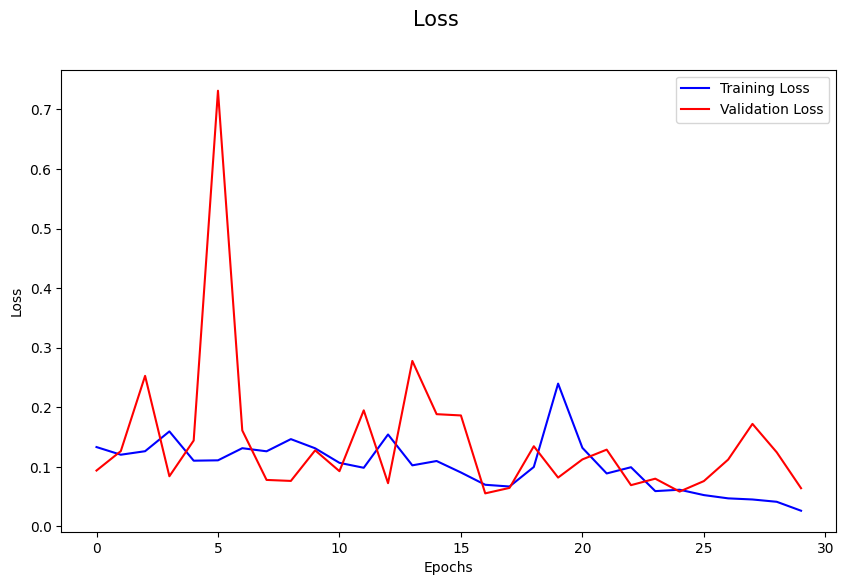

In [31]:
# Plotting the loss


fig=plt.figure(figsize=(10,6))
plt.plot(Cur_Model_Run.history['loss'], color='blue', label='Training Loss')
plt.plot(Cur_Model_Run.history['val_loss'], color='red', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
fig.suptitle('Loss',fontsize=15)
plt.legend()
plt.show()
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/SCRATCH_MODEL/Loss.eps', format='eps', dpi=600)
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/SCRATCH_MODEL/Loss.png', format='png', dpi=600)

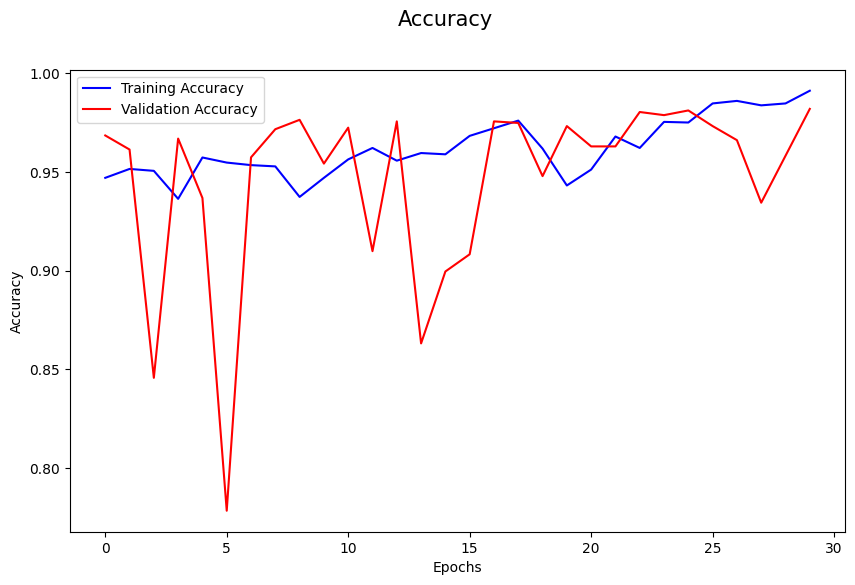

In [32]:
# Plotting the accuracy


fig=plt.figure(figsize=(10,6))
plt.plot(Cur_Model_Run.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(Cur_Model_Run.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
fig.suptitle('Accuracy',fontsize=15)
plt.legend()
plt.show()
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/SCRATCH_MODEL/Accuracy.eps', format='eps', dpi=600)
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/SCRATCH_MODEL/Accuracy.png', format='png', dpi=600)

### Calcualting Precision, Recall, Accuracy, F Score, Cohen-Kappa Score,ROC AUC and Log-Loss Score of the Model

In [33]:
pre = Precision()
re = Recall()
acc = Accuracy()

In [34]:
True_label=[]
Predicted_label=[]
Predicted_probabilities=[]
score=[]
for images,labels in (normalized_testing_set):
  score.append(model.evaluate(images,labels))
  for it in range(len(labels)):
    True_label.append(labels[it])
  pred=model.predict(images)
  y_max=[]
  for it in range(len(pred)):
      Predicted_probabilities.append(pred[it])
      y_max.append(np.argmax(pred[it]))
      Predicted_label.append(np.argmax(pred[it]))
  pre.update_state(labels,y_max)
  re.update_state(labels,y_max)
  acc.update_state(labels,y_max)

1/1 [==============================] - 0s 25ms/step


In [35]:
f_score=(2*pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy())

In [36]:
kappa=cohen_kappa_score(True_label,Predicted_label)

In [37]:
True_label=np.array(True_label)
Predicted_label=np.array(Predicted_label)
Predicted_probabilities=np.array(Predicted_probabilities)

In [38]:
Binarized_True_label=label_binarize(True_label,classes=[0, 1, 2, 3])

In [39]:
#Calcualting the fpr, tpr and auc


fpr = [0] * 4
tpr = [0] * 4
roc_auc= [0] * 4
avg_roc_auc=0
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(Binarized_True_label[:, i], Predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [40]:
roc_auc_details=[]
for i in range(4):
  temp=[CLASSES[i],roc_auc[i]]
  roc_auc_details.append(temp)

In [41]:
column_headers=['CLASS','ROC-AUC']
print('ROC-AUC Results')
print(tabulate(roc_auc_details, headers=column_headers, tablefmt="grid"))

ROC-AUC Results
+---------+-----------+
| CLASS   |   ROC-AUC |
+=========+===========+
| 60-40   |  1        |
+---------+-----------+
| 70-30   |  0.947075 |
+---------+-----------+
| 80-20   |  0.969665 |
+---------+-----------+
| 90-10   |  0.997758 |
+---------+-----------+


In [42]:
avg_roc_auc=sum(roc_auc)/4

In [43]:
print(f'The average ROC-AUC value is: {avg_roc_auc}')

The average ROC-AUC value is: 0.9786247229435217


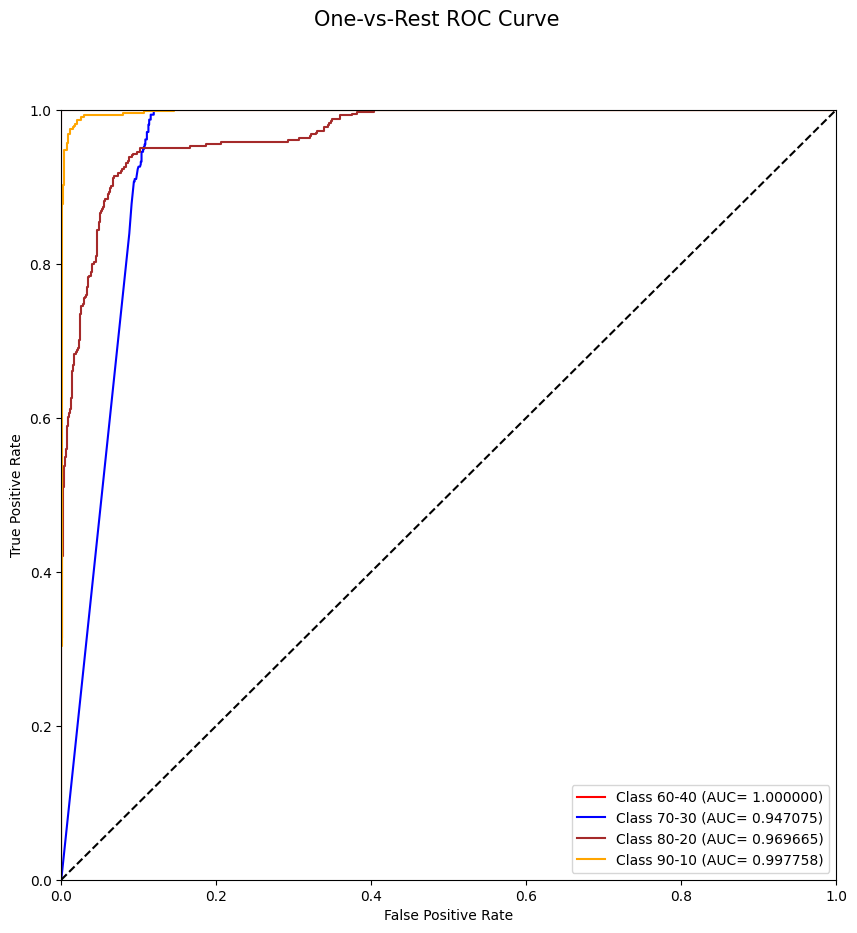

In [44]:
#Plotting the ROC Curve


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange']
for i in range(4):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/SCRATCH_MODEL/ROC_AUC.eps', format='eps', dpi=600)
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/SCRATCH_MODEL/ROC_AUC.png', format='png', dpi=600)

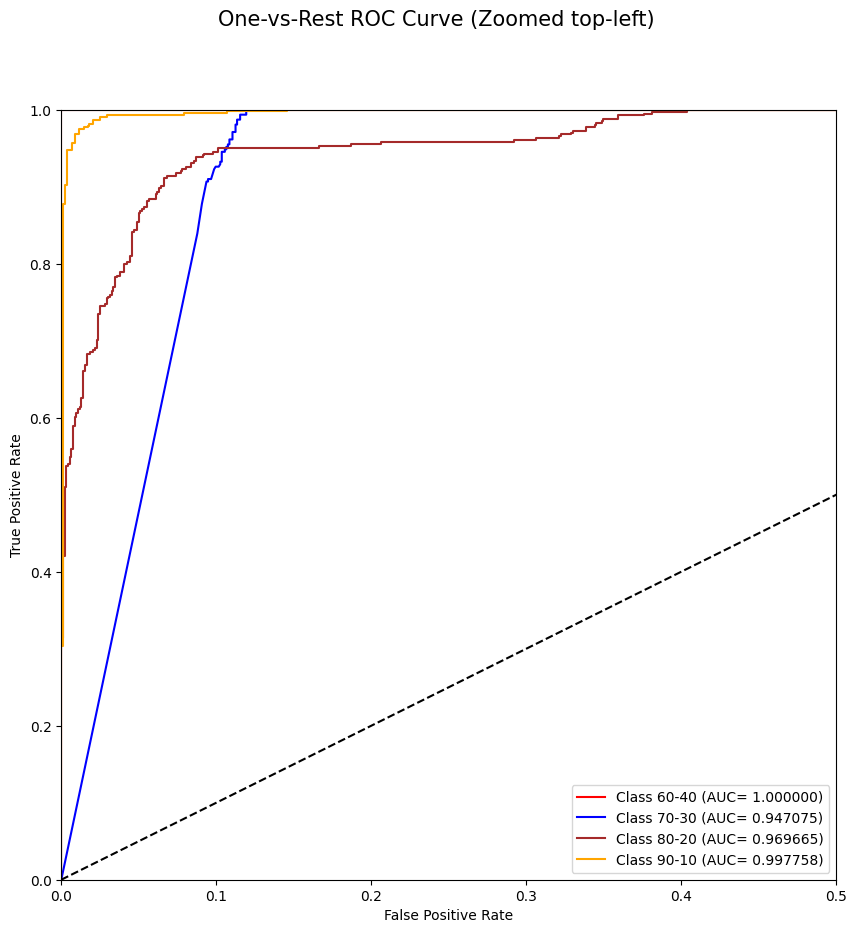

In [45]:
#Plotting the ROC Curve (Zoomed in at the top left corner)


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange']
for i in range(4):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 0.50])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve (Zoomed top-left)',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/SCRATCH_MODEL/ROC_AUC_Zoomed.eps', format='eps', dpi=600)
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/SCRATCH_MODEL/ROC_AUC_Zoomed.png', format='png', dpi=600)

In [46]:
#Calculating the Log-loss Score (One-vs-Rest)


temp=[0]*4
loss=[0]*4
epsilon = 1e-15  # Small constant to avoid division by zero
N = Binarized_True_label.shape[0]

for i in range(4):
  # Clip predicted probabilities to avoid log(0) cases
  temp[i]= np.clip(Predicted_probabilities[:,i], epsilon, 1 - epsilon)
  # Calculate cross-entropy loss
  loss[i] = -np.sum(Binarized_True_label[:,i] * np.log(temp[i])) / N

In [47]:
log_loss_result=[]
for i in range(4):
  log_loss_result.append([CLASSES[i],loss[i]])

In [48]:
column_headers=['CLASS','LOG-LOSS VALUE']
print('Log-Loss Results')
print(tabulate(log_loss_result, headers=column_headers, tablefmt="grid"))

Log-Loss Results
+---------+------------------+
| CLASS   |   LOG-LOSS VALUE |
+=========+==================+
| 60-40   |     -0           |
+---------+------------------+
| 70-30   |      6.86412e-07 |
+---------+------------------+
| 80-20   |      0.00880349  |
+---------+------------------+
| 90-10   |      0.0158732   |
+---------+------------------+


In [49]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}, F Score: {f_score}, Cohen Kappa Score: {kappa}')

Precision: 1.0, Recall: 1.0, Accuracy: 0.9818868041038513, F Score: 1.0, Cohen Kappa Score: 0.975042772606696


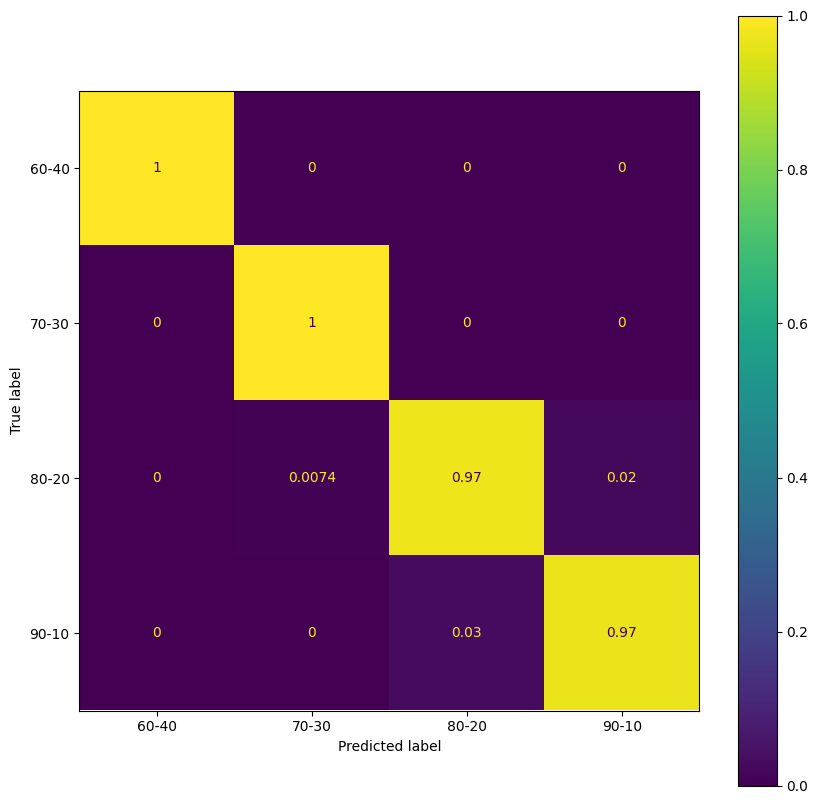

In [50]:
#Plotting the Confusion Matrix


confusion_matrix=metrics.confusion_matrix(True_label,Predicted_label,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["60-40","70-30","80-20","90-10"])
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.show()
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/SCRATCH_MODEL/Confusion_Matrix.eps', format='eps', dpi=600)
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/SCRATCH_MODEL/Confusion_Matrix.png', format='png', dpi=600)

### Demonstrating how to use the model

In [51]:
img=image.load_img('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/001_Dataset_Turmeric/Testing/80t20s/80t20s_14.jpg',target_size=(299,299))

In [52]:
x=image.img_to_array(img)

In [53]:
x=x/255

In [54]:
x=np.expand_dims(x,axis=0)
x.shape

(1, 299, 299, 3)

In [55]:
pred=model.predict(x)

1/1 [==============================] - 0s 357ms/step


In [56]:
print(pred)

[[7.1690320e-06 9.9980658e-01 9.9909270e-01 7.5521115e-07]]


In [57]:
pred_name = CLASSES[np.argmax(pred)]
print(pred_name)

70-30


In [58]:
temp_testing_set=normalized_testing_set.take(1)

pred_start=time.time()
for (images,labels) in (temp_testing_set):
  result=model.predict(images)
pred_stop=time.time()

1/1 [==============================] - 0s 31ms/step


In [59]:
print(f'Time requrired for giving prediction on one set of {len(labels)} images= {pred_stop-pred_start}')
print(f'Average time requrired for giving prediction on one image= {(pred_stop-pred_start)/len(labels)}')

Time requrired for giving prediction on one set of 16 images= 0.32546377182006836
Average time requrired for giving prediction on one image= 0.020341485738754272


# Training the VGG16 Model and evaluating the performance

In [60]:
from keras.applications import VGG16

In [61]:
vgg16_logdir='/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/003_Logs/VGG16_Logs'

In [62]:
vgg16_tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=vgg16_logdir)

In [63]:
vgg16_base=VGG16(weights='imagenet',include_top=False,input_shape=(299,299,3))
vgg16_model=Sequential()
vgg16_model.add(vgg16_base)
vgg16_model.add(Flatten())
vgg16_model.add(Dense(4,activation='sigmoid'))

vgg16_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [64]:
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 4)                 165892    
                                                                 
Total params: 14880580 (56.76 MB)
Trainable params: 14880580 (56.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [65]:
vgg16_Training_start=time.time()

In [67]:
vgg16_Model_Run = vgg16_model.fit(
    normalized_training_set,
    validation_data=normalized_validation_set,
    epochs=30,
    validation_steps=len(normalized_validation_set),
    callbacks=[vgg16_tensorboard_callback]
  )

Epoch 1/30
195/195 [==============================] - 109s 447ms/step - loss: 1.4179 - accuracy: 0.2455 - val_loss: 1.3855 - val_accuracy: 0.2959
Epoch 2/30
195/195 [==============================] - 81s 416ms/step - loss: 1.3856 - accuracy: 0.2587 - val_loss: 1.3846 - val_accuracy: 0.2959
Epoch 3/30
195/195 [==============================] - 82s 418ms/step - loss: 1.3853 - accuracy: 0.2613 - val_loss: 1.3842 - val_accuracy: 0.2959
Epoch 4/30
195/195 [==============================] - 82s 421ms/step - loss: 1.3851 - accuracy: 0.2638 - val_loss: 1.3839 - val_accuracy: 0.2959
Epoch 5/30
195/195 [==============================] - 82s 420ms/step - loss: 1.3850 - accuracy: 0.2638 - val_loss: 1.3837 - val_accuracy: 0.2959
Epoch 6/30
195/195 [==============================] - 82s 418ms/step - loss: 1.3850 - accuracy: 0.2638 - val_loss: 1.3836 - val_accuracy: 0.2959
Epoch 7/30
195/195 [==============================] - 83s 422ms/step - loss: 1.3850 - accuracy: 0.2638 - val_loss: 1.3836 - val_a

In [68]:
vgg16_Training_stop=time.time()

In [69]:
print(f'Time required for VGG16 model training= {vgg16_Training_stop-vgg16_Training_start} seconds')

Time required for VGG16 model training= 3230.967652320862 seconds


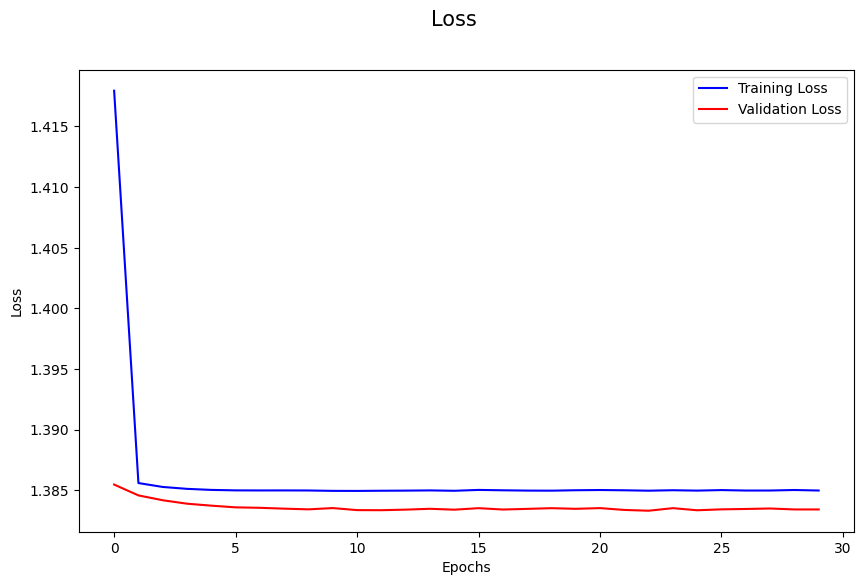

In [70]:
# Plotting the loss


fig=plt.figure(figsize=(10,6))
plt.plot(vgg16_Model_Run.history['loss'], color='blue', label='Training Loss')
plt.plot(vgg16_Model_Run.history['val_loss'], color='red', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
fig.suptitle('Loss',fontsize=15)
plt.legend()
plt.show()
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/VGG16/VGG16_Loss.eps', format='eps', dpi=600)
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/VGG16/VGG16_Loss.png', format='png', dpi=600)

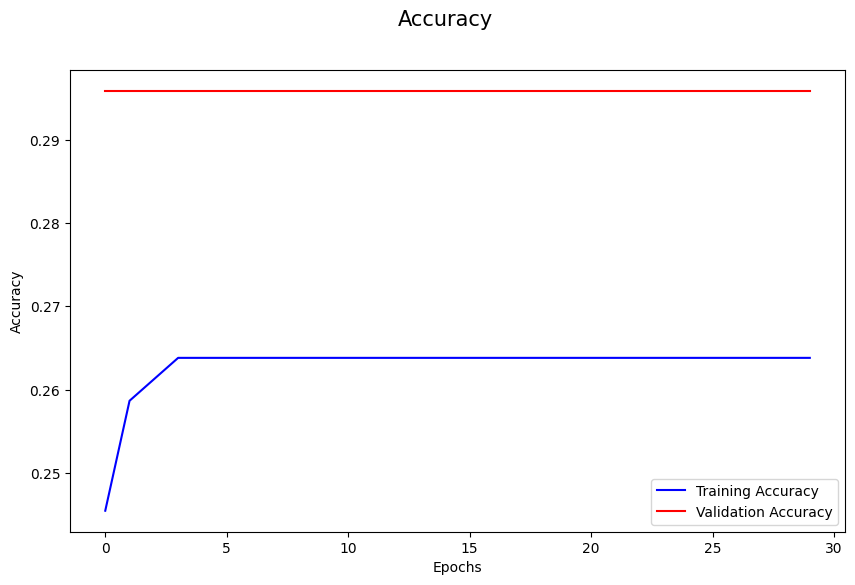

In [71]:
# Plotting the accuracy


fig=plt.figure(figsize=(10,6))
plt.plot(vgg16_Model_Run.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(vgg16_Model_Run.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
fig.suptitle('Accuracy',fontsize=15)
plt.legend()
plt.show()
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/VGG16/VGG16_Accuracy.eps', format='eps', dpi=600)
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/VGG16/VGG16_Accuracy.png', format='png', dpi=600)

In [72]:
# Calculating the Precision, Recall, Accuracy

pre = Precision()
re = Recall()
acc = Accuracy()

In [73]:
True_label=[]
Predicted_label=[]
Predicted_probabilities=[]
score=[]
for images,labels in (normalized_testing_set):
  score.append(vgg16_model.evaluate(images,labels))
  for it in range(len(labels)):
    True_label.append(labels[it])
  pred=vgg16_model.predict(images)
  y_max=[]
  for it in range(len(pred)):
      Predicted_probabilities.append(pred[it])
      y_max.append(np.argmax(pred[it]))
      Predicted_label.append(np.argmax(pred[it]))
  pre.update_state(labels,y_max)
  re.update_state(labels,y_max)
  acc.update_state(labels,y_max)

1/1 [==============================] - 0s 37ms/step


In [74]:
f_score=(2*pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy())

In [75]:
kappa=cohen_kappa_score(True_label,Predicted_label)

In [76]:
True_label=np.array(True_label)
Predicted_label=np.array(Predicted_label)
Predicted_probabilities=np.array(Predicted_probabilities)

In [77]:
Binarized_True_label=label_binarize(True_label,classes=[0, 1, 2, 3])

In [78]:
#Calcualting the fpr, tpr and auc


fpr = [0] * 4
tpr = [0] * 4
roc_auc= [0] * 4
avg_roc_auc=0
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(Binarized_True_label[:, i], Predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [79]:
roc_auc_details=[]
for i in range(4):
  temp=[CLASSES[i],roc_auc[i]]
  roc_auc_details.append(temp)

In [80]:
column_headers=['CLASS','ROC-AUC']
print('ROC-AUC Results')
print(tabulate(roc_auc_details, headers=column_headers, tablefmt="grid"))

ROC-AUC Results
+---------+-----------+
| CLASS   |   ROC-AUC |
+=========+===========+
| 60-40   |       0.5 |
+---------+-----------+
| 70-30   |       0.5 |
+---------+-----------+
| 80-20   |       0.5 |
+---------+-----------+
| 90-10   |       0.5 |
+---------+-----------+


In [81]:
avg_roc_auc=sum(roc_auc)/4

In [82]:
print(f'The average ROC-AUC value is: {avg_roc_auc}')

The average ROC-AUC value is: 0.5


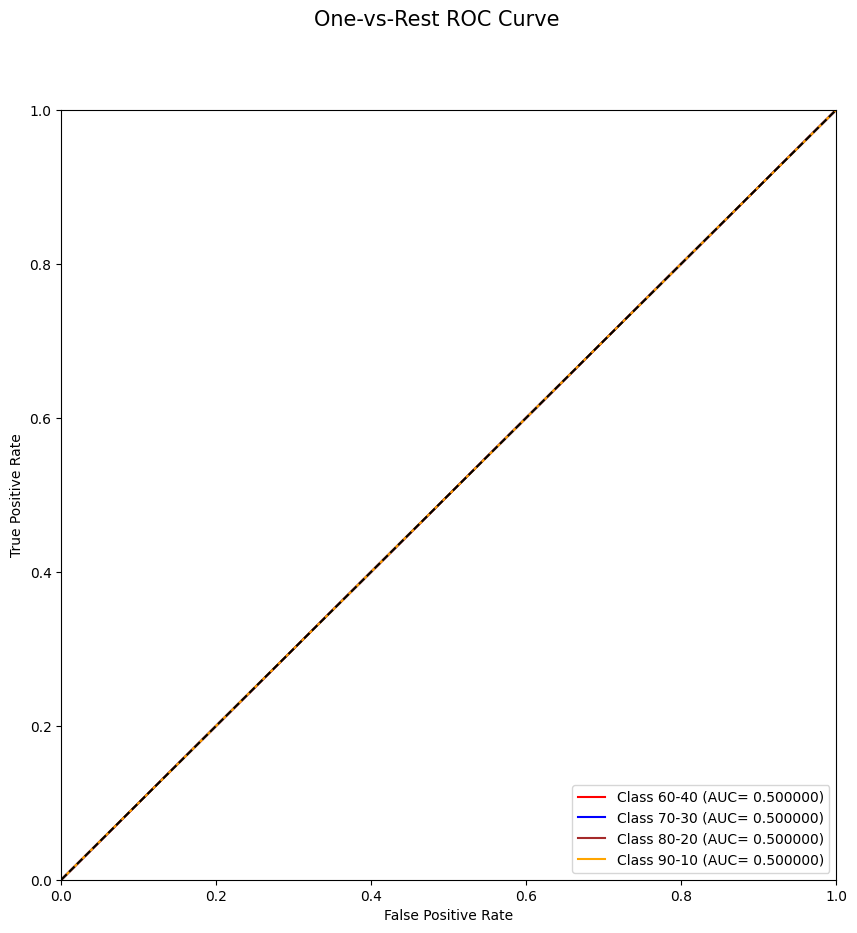

In [83]:
#Plotting the ROC Curve


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange']
for i in range(4):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/VGG16/VGG16_ROC_AUC.eps', format='eps', dpi=600)
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/VGG16/VGG16_ROC_AUC.png', format='png', dpi=600)

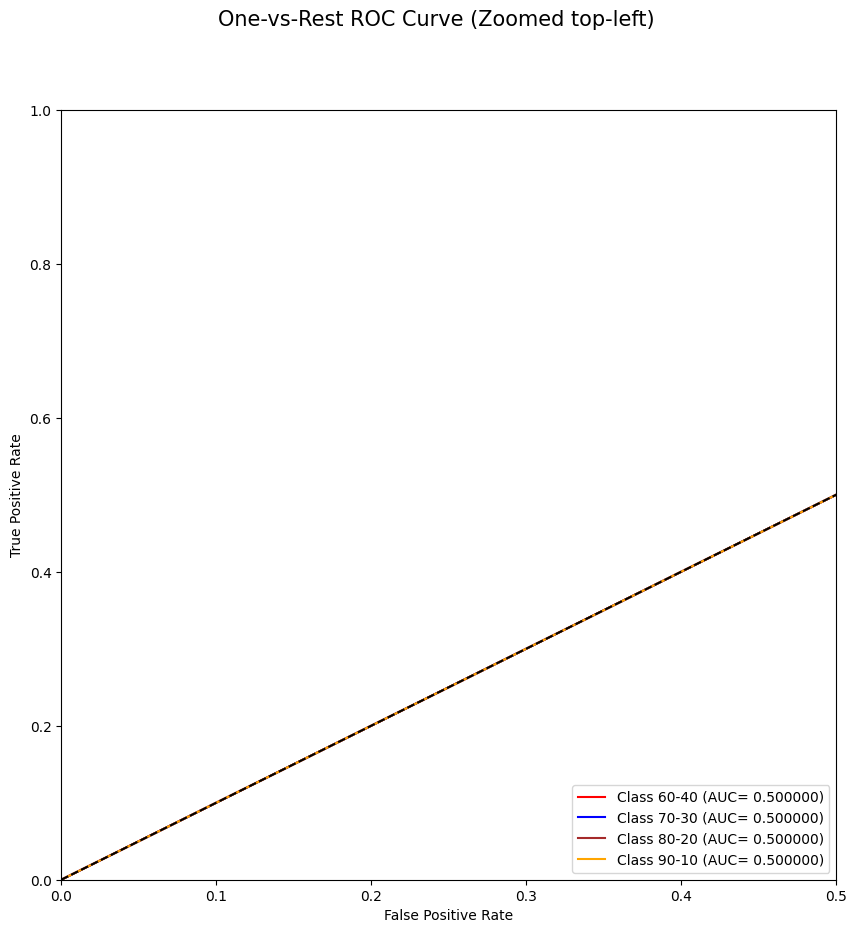

In [84]:
#Plotting the ROC Curve (Zoomed in at the top left corner)


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange']
for i in range(4):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 0.50])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve (Zoomed top-left)',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/VGG16/VGG16_ROC_AUC_Zoomed.eps', format='eps', dpi=600)
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/VGG16/VGG16_ROC_AUC_Zoomed.png', format='png', dpi=600)

In [85]:
#Calculating the Log-loss Score (One-vs-Rest)


temp=[0]*4
loss=[0]*4
epsilon = 1e-15  # Small constant to avoid division by zero
N = Binarized_True_label.shape[0]

for i in range(4):
  # Clip predicted probabilities to avoid log(0) cases
  temp[i]= np.clip(Predicted_probabilities[:,i], epsilon, 1 - epsilon)
  # Calculate cross-entropy loss
  loss[i] = -np.sum(Binarized_True_label[:,i] * np.log(temp[i])) / N

In [86]:
log_loss_result=[]
for i in range(4):
  log_loss_result.append([CLASSES[i],loss[i]])

In [87]:
column_headers=['CLASS','LOG-LOSS VALUE']
print('Log-Loss Results')
print(tabulate(log_loss_result, headers=column_headers, tablefmt="grid"))

Log-Loss Results
+---------+------------------+
| CLASS   |   LOG-LOSS VALUE |
+=========+==================+
| 60-40   |         0.095415 |
+---------+------------------+
| 70-30   |         0.15658  |
+---------+------------------+
| 80-20   |         0.208106 |
+---------+------------------+
| 90-10   |         0.227147 |
+---------+------------------+


In [88]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}, F Score: {f_score}, Cohen Kappa Score: {kappa}')

Precision: 0.8709433674812317, Recall: 1.0, Accuracy: 0.2347169816493988, F Score: 0.9310205860483313, Cohen Kappa Score: 0.0


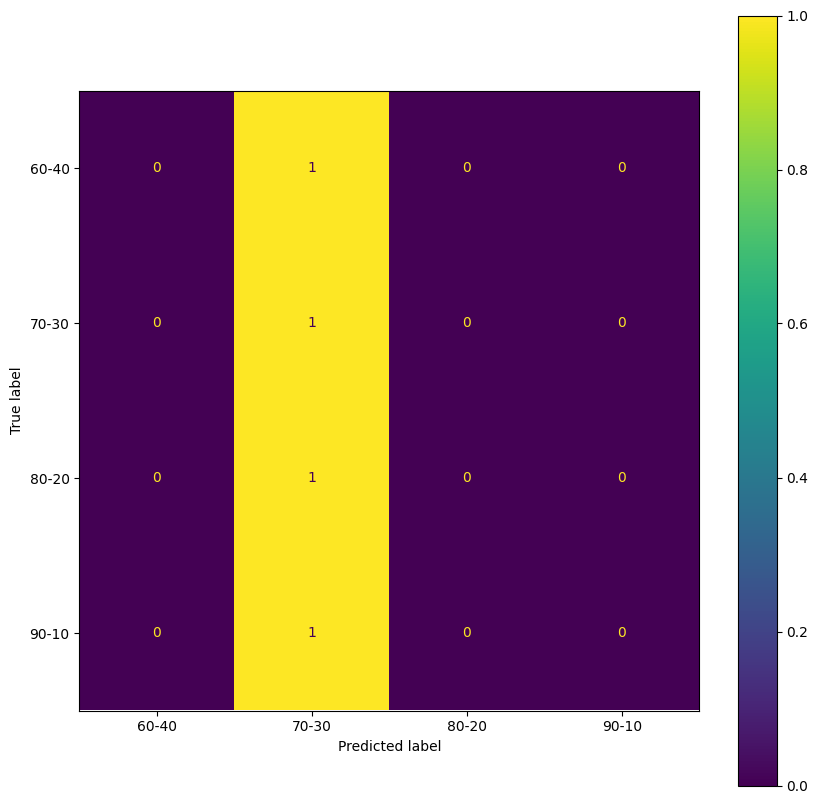

In [89]:
#Plotting the Confusion Matrix


confusion_matrix=metrics.confusion_matrix(True_label,Predicted_label,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["60-40","70-30","80-20","90-10"])
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.show()
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/VGG16/VGG16_Confusion_Matrix.eps', format='eps', dpi=600)
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/VGG16/VGG16_Confusion_Matrix.png', format='png', dpi=600)

# Training the  MobileNetV2 Model and evaluating the performance

In [90]:
from keras.applications import MobileNetV2

In [91]:
mobilenetv2_logdir='/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/003_Logs/MOBILENETV2_Logs'

In [92]:
mobilenetv2_tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=mobilenetv2_logdir)

In [93]:
mobilenetv2_base=MobileNetV2(weights='imagenet',include_top=False,input_shape=(299,299,3))
mobilenetv2_model=Sequential()
mobilenetv2_model.add(mobilenetv2_base)
mobilenetv2_model.add(Flatten())
mobilenetv2_model.add(Dense(4,activation='sigmoid'))

mobilenetv2_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step


In [94]:
mobilenetv2_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 10, 10, 1280)      2257984   
 tional)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 128000)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 512004    
                                                                 
Total params: 2769988 (10.57 MB)
Trainable params: 2735876 (10.44 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [95]:
mobilenetv2_Training_start=time.time()

In [96]:
mobilenetv2_Model_Run=mobilenetv2_model.fit(
    normalized_training_set,
    validation_data=normalized_validation_set,
    epochs=30,
    validation_steps=len(normalized_validation_set),
    callbacks=[mobilenetv2_tensorboard_callback]
)

Epoch 1/30
195/195 [==============================] - 58s 152ms/step - loss: 1.2628 - accuracy: 0.8285 - val_loss: 137.9184 - val_accuracy: 0.2247
Epoch 2/30
195/195 [==============================] - 29s 149ms/step - loss: 2.1577 - accuracy: 0.8121 - val_loss: 446.3492 - val_accuracy: 0.2959
Epoch 3/30
195/195 [==============================] - 28s 143ms/step - loss: 1.0921 - accuracy: 0.8356 - val_loss: 718.6921 - val_accuracy: 0.2247
Epoch 4/30
195/195 [==============================] - 30s 150ms/step - loss: 0.6386 - accuracy: 0.9115 - val_loss: 680.9178 - val_accuracy: 0.2247
Epoch 5/30
195/195 [==============================] - 29s 150ms/step - loss: 0.7974 - accuracy: 0.8880 - val_loss: 397.5066 - val_accuracy: 0.2247
Epoch 6/30
195/195 [==============================] - 30s 151ms/step - loss: 0.9004 - accuracy: 0.8893 - val_loss: 347.3359 - val_accuracy: 0.2247
Epoch 7/30
195/195 [==============================] - 28s 143ms/step - loss: 0.4976 - accuracy: 0.9286 - val_loss: 195

In [97]:
mobilenetv2_Training_stop=time.time()

In [98]:
print(f'Time required for MOBILENETV2 model training= {mobilenetv2_Training_stop-mobilenetv2_Training_start} seconds')

Time required for MOBILENETV2 model training= 1103.35267162323 seconds


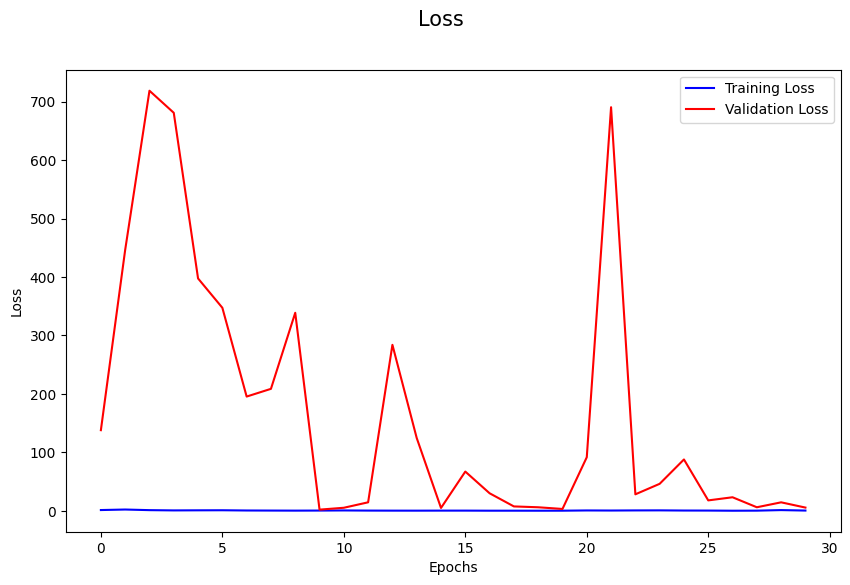

In [99]:
# Plotting the loss


fig=plt.figure(figsize=(10,6))
plt.plot(mobilenetv2_Model_Run.history['loss'], color='blue', label='Training Loss')
plt.plot(mobilenetv2_Model_Run.history['val_loss'], color='red', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
fig.suptitle('Loss',fontsize=15)
plt.legend()
plt.show()
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/MOBILENETV2/MOBILENETV2_Loss.eps', format='eps', dpi=600)
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/MOBILENETV2/MOBILENETV2_Loss.png', format='png', dpi=600)

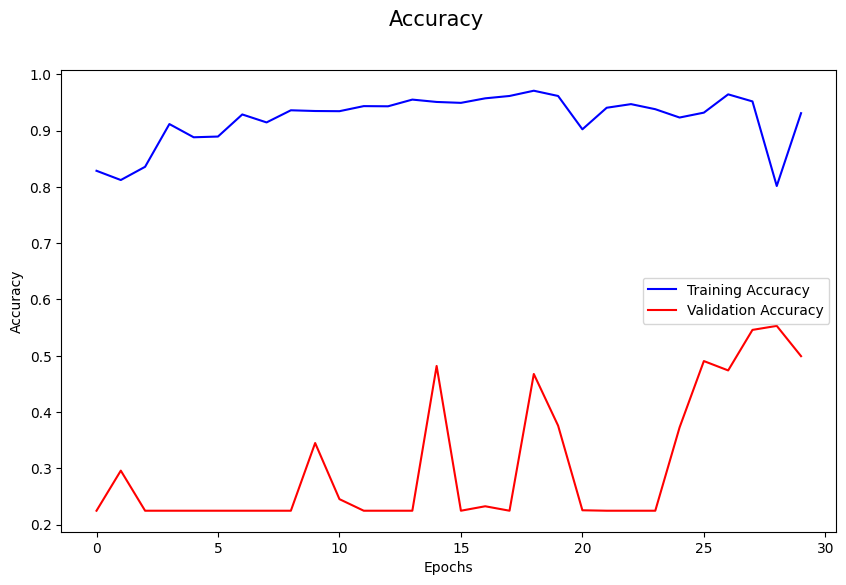

In [100]:
# Plotting the accuracy


fig=plt.figure(figsize=(10,6))
plt.plot(mobilenetv2_Model_Run.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(mobilenetv2_Model_Run.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
fig.suptitle('Accuracy',fontsize=15)
plt.legend()
plt.show()
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/MOBILENETV2/MOBILENETV2_Accuracy.eps', format='eps', dpi=600)
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/MOBILENETV2/MOBILENETV2_Accuracy.png', format='png', dpi=600)

In [101]:
# Calculating the Precision, Recall, Accuracy

pre = Precision()
re = Recall()
acc = Accuracy()

In [102]:
True_label=[]
Predicted_label=[]
Predicted_probabilities=[]
score=[]
for images,labels in (normalized_testing_set):
  score.append(mobilenetv2_model.evaluate(images,labels))
  for it in range(len(labels)):
    True_label.append(labels[it])
  pred=mobilenetv2_model.predict(images)
  y_max=[]
  for it in range(len(pred)):
      Predicted_probabilities.append(pred[it])
      y_max.append(np.argmax(pred[it]))
      Predicted_label.append(np.argmax(pred[it]))
  pre.update_state(labels,y_max)
  re.update_state(labels,y_max)
  acc.update_state(labels,y_max)

1/1 [==============================] - 0s 28ms/step


In [103]:
f_score=(2*pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy())

In [104]:
kappa=cohen_kappa_score(True_label,Predicted_label)

In [105]:
True_label=np.array(True_label)
Predicted_label=np.array(Predicted_label)
Predicted_probabilities=np.array(Predicted_probabilities)

In [106]:
Binarized_True_label=label_binarize(True_label,classes=[0, 1, 2, 3])

In [107]:
#Calcualting the fpr, tpr and auc


fpr = [0] * 4
tpr = [0] * 4
roc_auc= [0] * 4
avg_roc_auc=0
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(Binarized_True_label[:, i], Predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [108]:
roc_auc_details=[]
for i in range(4):
  temp=[CLASSES[i],roc_auc[i]]
  roc_auc_details.append(temp)

In [109]:
column_headers=['CLASS','ROC-AUC']
print('ROC-AUC Results')
print(tabulate(roc_auc_details, headers=column_headers, tablefmt="grid"))

ROC-AUC Results
+---------+-----------+
| CLASS   |   ROC-AUC |
+=========+===========+
| 60-40   |  1        |
+---------+-----------+
| 70-30   |  0.994549 |
+---------+-----------+
| 80-20   |  0.674272 |
+---------+-----------+
| 90-10   |  0.892643 |
+---------+-----------+


In [110]:
avg_roc_auc=sum(roc_auc)/4

In [111]:
print(f'The average ROC-AUC value is: {avg_roc_auc}')

The average ROC-AUC value is: 0.8903660727388325


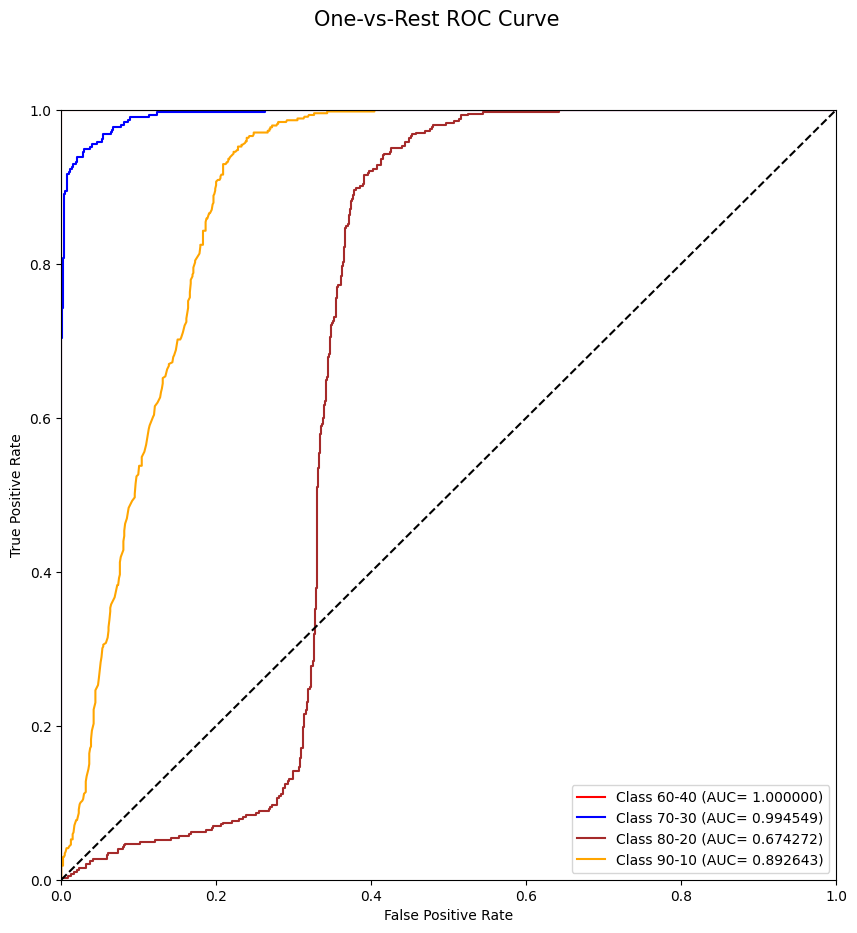

In [112]:
#Plotting the ROC Curve


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange']
for i in range(4):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/MOBILENETV2/MOBILENETV2_ROC_AUC.eps', format='eps', dpi=600)
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/MOBILENETV2/MOBILENETV2_ROC_AUC.png', format='png', dpi=600)

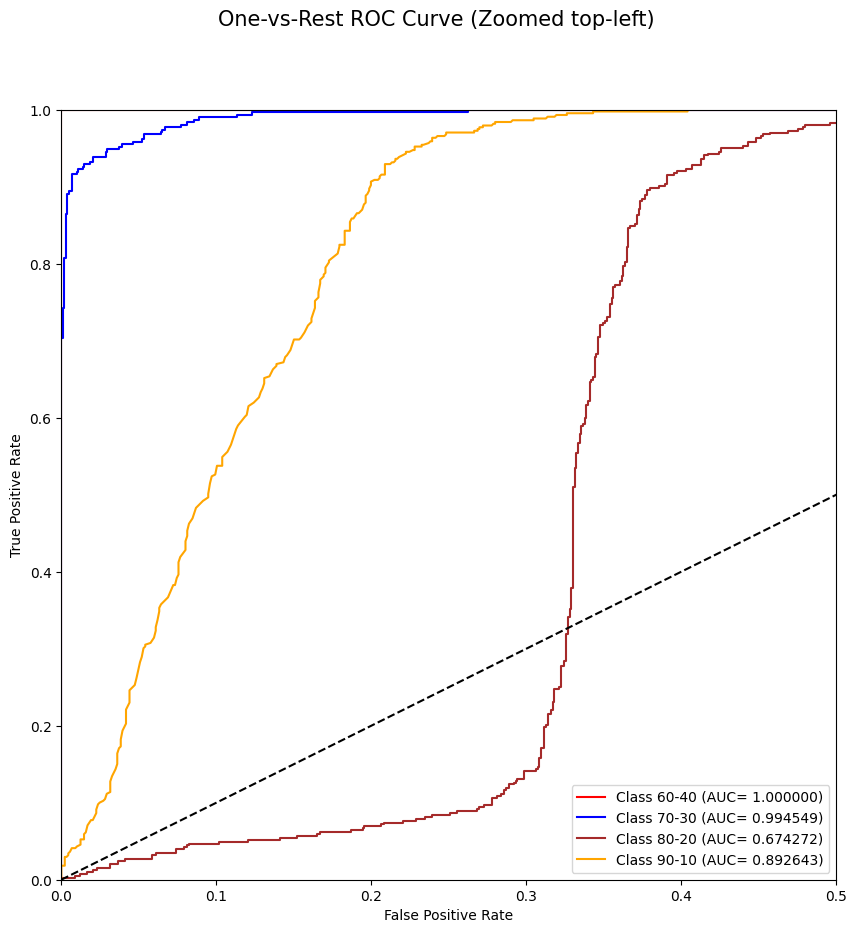

In [113]:
#Plotting the ROC Curve (Zoomed in at the top left corner)


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange']
for i in range(4):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 0.50])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve (Zoomed top-left)',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/MOBILENETV2/MOBILENETV2_ROC_AUC_Zoomed.eps', format='eps', dpi=600)
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/MOBILENETV2/MOBILENETV2_ROC_AUC_Zoomed.png', format='png', dpi=600)

In [114]:
#Calculating the Log-loss Score (One-vs-Rest)


temp=[0]*4
loss=[0]*4
epsilon = 1e-15  # Small constant to avoid division by zero
N = Binarized_True_label.shape[0]

for i in range(4):
  # Clip predicted probabilities to avoid log(0) cases
  temp[i]= np.clip(Predicted_probabilities[:,i], epsilon, 1 - epsilon)
  # Calculate cross-entropy loss
  loss[i] = -np.sum(Binarized_True_label[:,i] * np.log(temp[i])) / N

In [115]:
log_loss_result=[]
for i in range(4):
  log_loss_result.append([CLASSES[i],loss[i]])

In [116]:
column_headers=['CLASS','LOG-LOSS VALUE']
print('Log-Loss Results')
print(tabulate(log_loss_result, headers=column_headers, tablefmt="grid"))

Log-Loss Results
+---------+------------------+
| CLASS   |   LOG-LOSS VALUE |
+=========+==================+
| 60-40   |     -0           |
+---------+------------------+
| 70-30   |      1.16898     |
+---------+------------------+
| 80-20   |      0.799041    |
+---------+------------------+
| 90-10   |      9.73708e-06 |
+---------+------------------+


In [117]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}, F Score: {f_score}, Cohen Kappa Score: {kappa}')

Precision: 1.0, Recall: 0.9991334676742554, Accuracy: 0.505660355091095, F Score: 0.999566546036192, Cohen Kappa Score: 0.2968572771170237


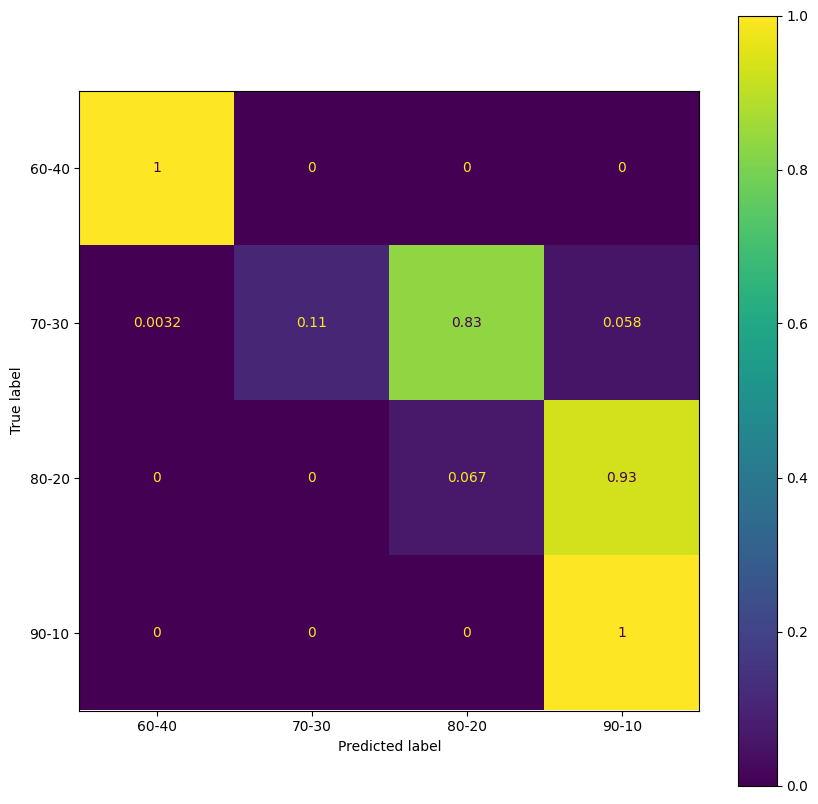

In [118]:
#Plotting the Confusion Matrix


confusion_matrix=metrics.confusion_matrix(True_label,Predicted_label,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["60-40","70-30","80-20","90-10"])
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.show()
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/MOBILENETV2/MOBILENETV2_Confusion_Matrix.eps', format='eps', dpi=600)
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/MOBILENETV2/MOBILENETV2_Confusion_Matrix.png', format='png', dpi=600)

# Training the ResNet50 Model and evaluating the performance

In [119]:
from keras.applications import ResNet50

In [120]:
resnet50_logdir='/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/003_Logs/RESNET50_Logs'

In [121]:
resnet50_tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=resnet50_logdir)

In [122]:
resnet50_base=ResNet50(weights='imagenet',include_top=False,input_shape=(299,299,3))
resnet50_model=Sequential()
resnet50_model.add(resnet50_base)
resnet50_model.add(Flatten())
resnet50_model.add(Dense(4,activation='sigmoid'))

resnet50_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

94765736/94765736 [==============================] - 1s 0us/step


In [123]:
resnet50_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten_2 (Flatten)         (None, 204800)            0         
                                                                 
 dense_2 (Dense)             (None, 4)                 819204    
                                                                 
Total params: 24406916 (93.10 MB)
Trainable params: 24353796 (92.90 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [124]:
resnet50_Training_start=time.time()

In [125]:
resnet50_Model_Run=resnet50_model.fit(
    normalized_training_set,
    validation_data=normalized_validation_set,
    epochs=30,
    validation_steps=len(normalized_validation_set),
    callbacks=[resnet50_tensorboard_callback]
)

Epoch 1/30
195/195 [==============================] - 111s 375ms/step - loss: 4.4397 - accuracy: 0.8481 - val_loss: 2.7158 - val_accuracy: 0.2959
Epoch 2/30
195/195 [==============================] - 70s 357ms/step - loss: 2.5138 - accuracy: 0.8993 - val_loss: 2.6940 - val_accuracy: 0.2247
Epoch 3/30
195/195 [==============================] - 68s 346ms/step - loss: 2.6708 - accuracy: 0.9048 - val_loss: 7.4206 - val_accuracy: 0.2959
Epoch 4/30
195/195 [==============================] - 70s 360ms/step - loss: 0.4532 - accuracy: 0.9517 - val_loss: 1.7924 - val_accuracy: 0.2247
Epoch 5/30
195/195 [==============================] - 70s 356ms/step - loss: 0.5985 - accuracy: 0.9427 - val_loss: 3.3202 - val_accuracy: 0.0625
Epoch 6/30
195/195 [==============================] - 67s 345ms/step - loss: 1.4257 - accuracy: 0.9073 - val_loss: 1.7122 - val_accuracy: 0.3062
Epoch 7/30
195/195 [==============================] - 70s 356ms/step - loss: 0.9173 - accuracy: 0.9260 - val_loss: 2.7111 - val_a

In [126]:
resnet50_Training_stop=time.time()

In [127]:
print(f'Time required for RESNET50 model training= {resnet50_Training_stop-resnet50_Training_start} seconds')

Time required for RESNET50 model training= 2328.592689037323 seconds


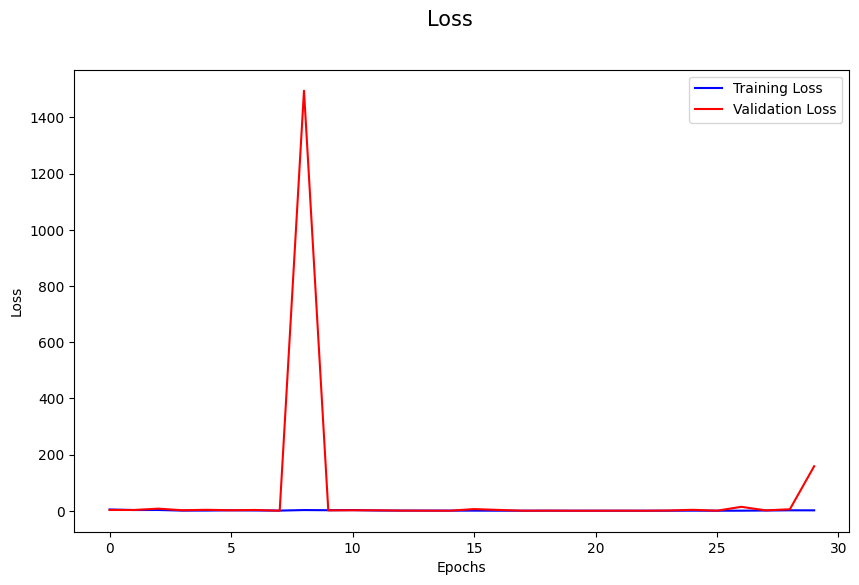

In [128]:
# Plotting the loss


fig=plt.figure(figsize=(10,6))
plt.plot(resnet50_Model_Run.history['loss'], color='blue', label='Training Loss')
plt.plot(resnet50_Model_Run.history['val_loss'], color='red', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
fig.suptitle('Loss',fontsize=15)
plt.legend()
plt.show()
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/RESNET50/RESNET50_Loss.eps', format='eps', dpi=600)
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/RESNET50/RESNET50_Loss.png', format='png', dpi=600)

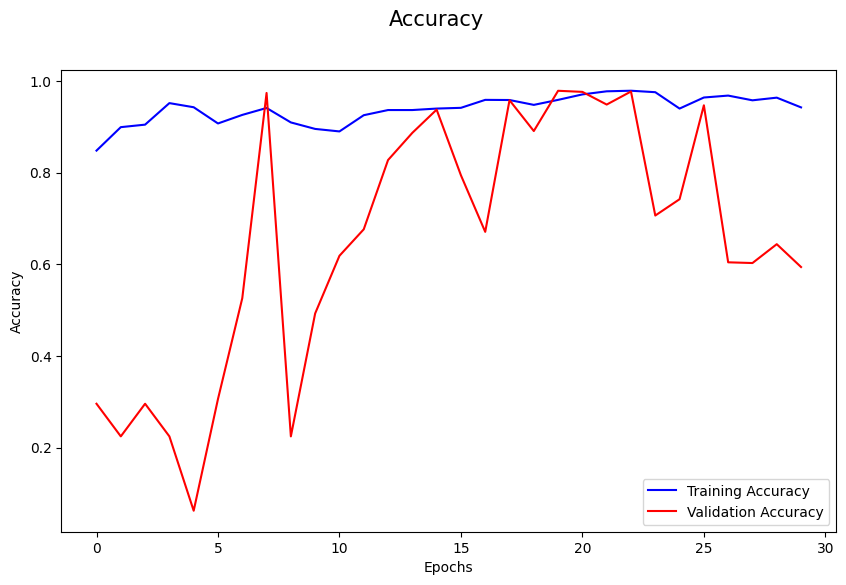

In [129]:
# Plotting the accuracy


fig=plt.figure(figsize=(10,6))
plt.plot(resnet50_Model_Run.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(resnet50_Model_Run.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
fig.suptitle('Accuracy',fontsize=15)
plt.legend()
plt.show()
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/RESNET50/RESNET50_Accuracy.eps', format='eps', dpi=600)
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/RESNET50/RESNET50_Accuracy.png', format='png', dpi=600)

In [130]:
# Calculating the Precision, Recall, Accuracy

pre = Precision()
re = Recall()
acc = Accuracy()

In [131]:
True_label=[]
Predicted_label=[]
Predicted_probabilities=[]
score=[]
for images,labels in (normalized_testing_set):
  score.append(resnet50_model.evaluate(images,labels))
  for it in range(len(labels)):
    True_label.append(labels[it])
  pred=resnet50_model.predict(images)
  y_max=[]
  for it in range(len(pred)):
      Predicted_probabilities.append(pred[it])
      y_max.append(np.argmax(pred[it]))
      Predicted_label.append(np.argmax(pred[it]))
  pre.update_state(labels,y_max)
  re.update_state(labels,y_max)
  acc.update_state(labels,y_max)

1/1 [==============================] - 0s 47ms/step


In [132]:
f_score=(2*pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy())

In [133]:
kappa=cohen_kappa_score(True_label,Predicted_label)

In [134]:
True_label=np.array(True_label)
Predicted_label=np.array(Predicted_label)
Predicted_probabilities=np.array(Predicted_probabilities)

In [135]:
Binarized_True_label=label_binarize(True_label,classes=[0, 1, 2, 3])

In [136]:
#Calcualting the fpr, tpr and auc


fpr = [0] * 4
tpr = [0] * 4
roc_auc= [0] * 4
avg_roc_auc=0
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(Binarized_True_label[:, i], Predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [137]:
roc_auc_details=[]
for i in range(4):
  temp=[CLASSES[i],roc_auc[i]]
  roc_auc_details.append(temp)

In [138]:
column_headers=['CLASS','ROC-AUC']
print('ROC-AUC Results')
print(tabulate(roc_auc_details, headers=column_headers, tablefmt="grid"))

ROC-AUC Results
+---------+-----------+
| CLASS   |   ROC-AUC |
+=========+===========+
| 60-40   |  0.917964 |
+---------+-----------+
| 70-30   |  0.936514 |
+---------+-----------+
| 80-20   |  0.710004 |
+---------+-----------+
| 90-10   |  0.85503  |
+---------+-----------+


In [139]:
avg_roc_auc=sum(roc_auc)/4

In [140]:
print(f'The average ROC-AUC value is: {avg_roc_auc}')

The average ROC-AUC value is: 0.8548780581658961


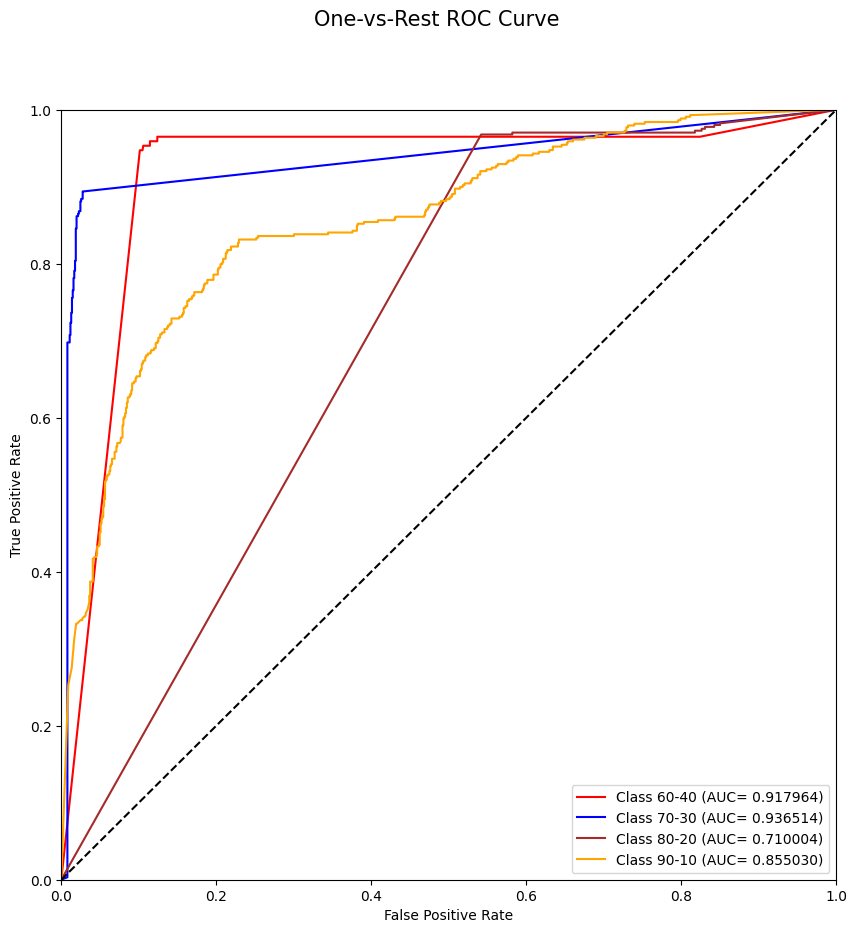

In [141]:
#Plotting the ROC Curve


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange']
for i in range(4):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/RESNET50/RESNET50_ROC_AUC.eps', format='eps', dpi=600)
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/RESNET50/RESNET50_ROC_AUC.png', format='png', dpi=600)

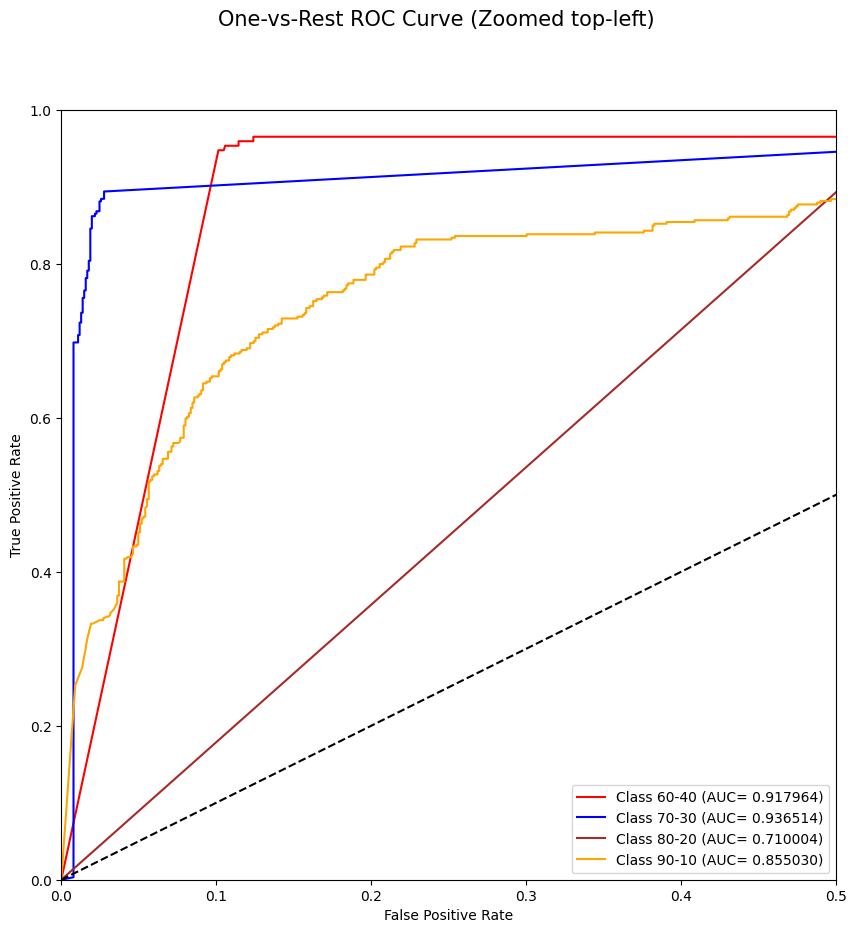

In [142]:
#Plotting the ROC Curve (Zoomed in at the top left corner)


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange']
for i in range(4):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 0.50])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve (Zoomed top-left)',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/RESNET50/RESNET50_ROC_AUC_Zoomed.eps', format='eps', dpi=600)
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/RESNET50/RESNET50_ROC_AUC_Zoomed.png', format='png', dpi=600)

In [143]:
#Calculating the Log-loss Score (One-vs-Rest)


temp=[0]*4
loss=[0]*4
epsilon = 1e-15  # Small constant to avoid division by zero
N = Binarized_True_label.shape[0]

for i in range(4):
  # Clip predicted probabilities to avoid log(0) cases
  temp[i]= np.clip(Predicted_probabilities[:,i], epsilon, 1 - epsilon)
  # Calculate cross-entropy loss
  loss[i] = -np.sum(Binarized_True_label[:,i] * np.log(temp[i])) / N

In [144]:
log_loss_result=[]
for i in range(4):
  log_loss_result.append([CLASSES[i],loss[i]])

In [145]:
column_headers=['CLASS','LOG-LOSS VALUE']
print('Log-Loss Results')
print(tabulate(log_loss_result, headers=column_headers, tablefmt="grid"))

Log-Loss Results
+---------+------------------+
| CLASS   |   LOG-LOSS VALUE |
+=========+==================+
| 60-40   |         0.156404 |
+---------+------------------+
| 70-30   |         1.93217  |
+---------+------------------+
| 80-20   |         0.27242  |
+---------+------------------+
| 90-10   |         0.636706 |
+---------+------------------+


In [146]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}, F Score: {f_score}, Cohen Kappa Score: {kappa}')

Precision: 0.9942362904548645, Recall: 0.8968803882598877, Accuracy: 0.5169811248779297, F Score: 0.9430523968689324, Cohen Kappa Score: 0.3511238641798182


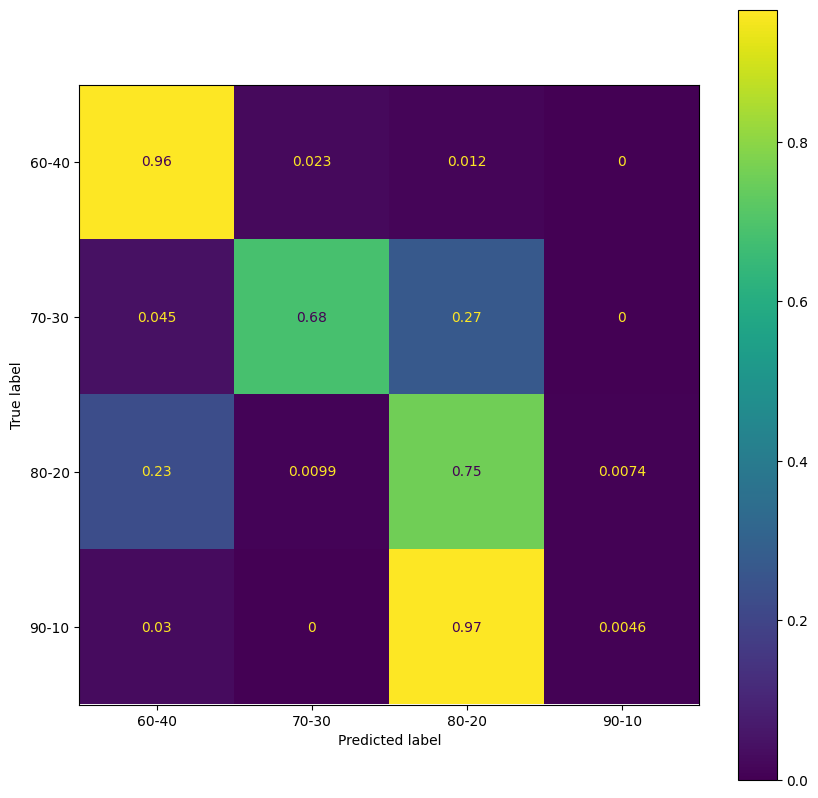

In [147]:
#Plotting the Confusion Matrix


confusion_matrix=metrics.confusion_matrix(True_label,Predicted_label,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["60-40","70-30","80-20","90-10"])
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.show()
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/RESNET50/RESNET50_Confusion_Matrix.eps', format='eps', dpi=600)
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/RESNET50/RESNET50_Confusion_Matrix.png', format='png', dpi=600)

# Training the EfficientNetB0 Model and evaluating the performance

In [148]:
from keras.applications import EfficientNetB0

In [149]:
efficientnetb0_logdir='/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/003_Logs/EFFICIENTNETB0_Logs'

In [150]:
efficientnetb0_tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=efficientnetb0_logdir)

In [151]:
efficientnetb0_base=EfficientNetB0(weights='imagenet',include_top=False,input_shape=(299,299,3))
efficientnetb0_model=Sequential()
efficientnetb0_model.add(efficientnetb0_base)
efficientnetb0_model.add(Flatten())
efficientnetb0_model.add(Dense(4,activation='sigmoid'))

efficientnetb0_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

16705208/16705208 [==============================] - 0s 0us/step


In [152]:
efficientnetb0_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 10, 10, 1280)      4049571   
 )                                                               
                                                                 
 flatten_3 (Flatten)         (None, 128000)            0         
                                                                 
 dense_3 (Dense)             (None, 4)                 512004    
                                                                 
Total params: 4561575 (17.40 MB)
Trainable params: 4519552 (17.24 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________


In [153]:
efficientnetb0_Training_start=time.time()

In [154]:
efficientnetb0_Model_Run=efficientnetb0_model.fit(
    normalized_training_set,
    validation_data=normalized_validation_set,
    epochs=30,
    validation_steps=len(normalized_validation_set),
    callbacks=[efficientnetb0_tensorboard_callback]
)

Epoch 1/30
195/195 [==============================] - 99s 290ms/step - loss: 1.9445 - accuracy: 0.8526 - val_loss: 147.1163 - val_accuracy: 0.2453
Epoch 2/30
195/195 [==============================] - 54s 276ms/step - loss: 1.7303 - accuracy: 0.8848 - val_loss: 17.8026 - val_accuracy: 0.2342
Epoch 3/30
195/195 [==============================] - 55s 281ms/step - loss: 1.4624 - accuracy: 0.9083 - val_loss: 5473.4307 - val_accuracy: 0.2342
Epoch 4/30
195/195 [==============================] - 55s 279ms/step - loss: 1.7644 - accuracy: 0.9125 - val_loss: 49.9747 - val_accuracy: 0.2959
Epoch 5/30
195/195 [==============================] - 54s 277ms/step - loss: 1.4512 - accuracy: 0.9205 - val_loss: 3483.1724 - val_accuracy: 0.2508
Epoch 6/30
195/195 [==============================] - 55s 280ms/step - loss: 0.8316 - accuracy: 0.9488 - val_loss: 12.8813 - val_accuracy: 0.2294
Epoch 7/30
195/195 [==============================] - 54s 279ms/step - loss: 0.5283 - accuracy: 0.9646 - val_loss: 39.3

In [155]:
efficientnetb0_Training_stop=time.time()

In [156]:
print(f'Time requied for EFFICIENTNETB0 model training= {efficientnetb0_Training_stop-efficientnetb0_Training_start} seconds')

Time requied for EFFICIENTNETB0 model training= 2038.3783321380615 seconds


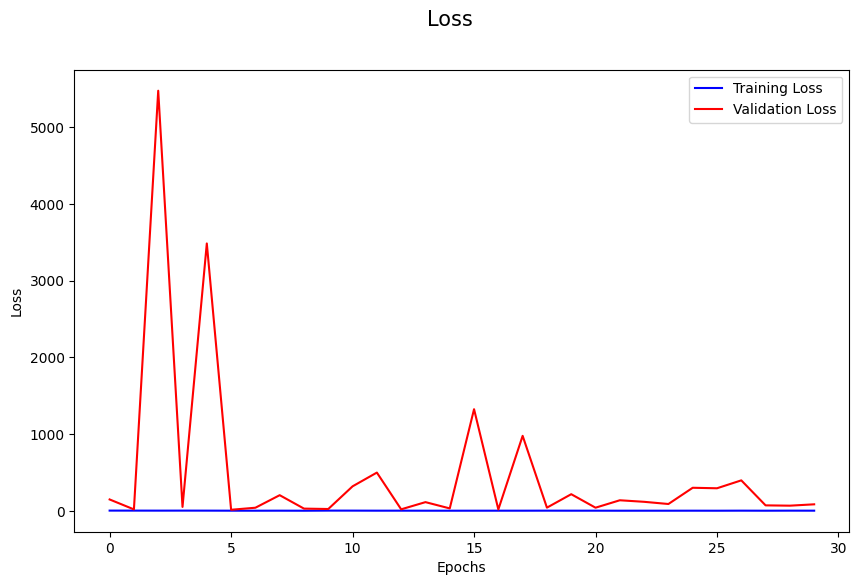

In [157]:
# Plotting the loss


fig=plt.figure(figsize=(10,6))
plt.plot(efficientnetb0_Model_Run.history['loss'], color='blue', label='Training Loss')
plt.plot(efficientnetb0_Model_Run.history['val_loss'], color='red', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
fig.suptitle('Loss',fontsize=15)
plt.legend()
plt.show()
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/EFFICIENTNETB0/EFFICIENTNETB0_Loss.eps', format='eps', dpi=600)
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/EFFICIENTNETB0/EFFICIENTNETB0_Loss.png', format='png', dpi=600)

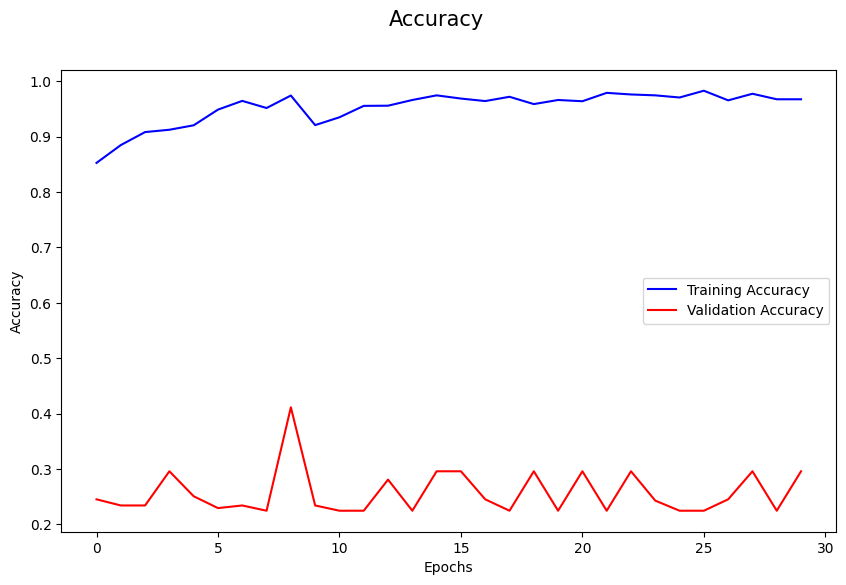

In [158]:
# Plotting the accuracy


fig=plt.figure(figsize=(10,6))
plt.plot(efficientnetb0_Model_Run.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(efficientnetb0_Model_Run.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
fig.suptitle('Accuracy',fontsize=15)
plt.legend()
plt.show()
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/EFFICIENTNETB0/EFFICIENTNETB0_Accuracy.eps', format='eps', dpi=600)
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/EFFICIENTNETB0/EFFICIENTNETB0_Accuracy.png', format='png', dpi=600)

In [159]:
# Calculating the Precision, Recall, Accuracy

pre = Precision()
re = Recall()
acc = Accuracy()

In [160]:
True_label=[]
Predicted_label=[]
Predicted_probabilities=[]
score=[]
for images,labels in (normalized_testing_set):
  score.append(efficientnetb0_model.evaluate(images,labels))
  for it in range(len(labels)):
    True_label.append(labels[it])
  pred=efficientnetb0_model.predict(images)
  y_max=[]
  for it in range(len(pred)):
      Predicted_probabilities.append(pred[it])
      y_max.append(np.argmax(pred[it]))
      Predicted_label.append(np.argmax(pred[it]))
  pre.update_state(labels,y_max)
  re.update_state(labels,y_max)
  acc.update_state(labels,y_max)

1/1 [==============================] - 0s 31ms/step


In [161]:
f_score=(2*pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy())

In [162]:
kappa=cohen_kappa_score(True_label,Predicted_label)

In [163]:
True_label=np.array(True_label)
Predicted_label=np.array(Predicted_label)
Predicted_probabilities=np.array(Predicted_probabilities)

In [164]:
Binarized_True_label=label_binarize(True_label,classes=[0, 1, 2, 3])

In [165]:
#Calcualting the fpr, tpr and auc


fpr = [0] * 4
tpr = [0] * 4
roc_auc= [0] * 4
avg_roc_auc=0
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(Binarized_True_label[:, i], Predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [166]:
roc_auc_details=[]
for i in range(4):
  temp=[CLASSES[i],roc_auc[i]]
  roc_auc_details.append(temp)

In [167]:
column_headers=['CLASS','ROC-AUC']
print('ROC-AUC Results')
print(tabulate(roc_auc_details, headers=column_headers, tablefmt="grid"))

ROC-AUC Results
+---------+-----------+
| CLASS   |   ROC-AUC |
+=========+===========+
| 60-40   |  0.981235 |
+---------+-----------+
| 70-30   |  0.5      |
+---------+-----------+
| 80-20   |  0.563495 |
+---------+-----------+
| 90-10   |  0.305842 |
+---------+-----------+


In [168]:
avg_roc_auc=sum(roc_auc)/4

In [169]:
print(f'The average ROC-AUC value is: {avg_roc_auc}')

The average ROC-AUC value is: 0.587643002677606


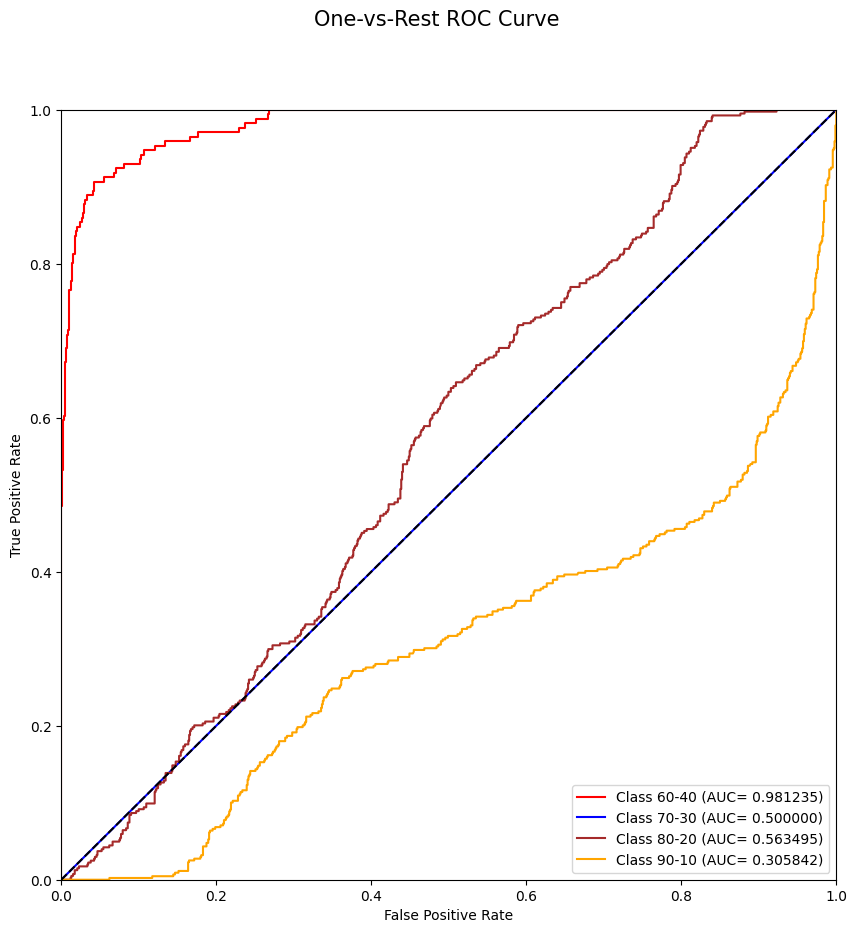

In [170]:
#Plotting the ROC Curve


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange']
for i in range(4):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/EFFICIENTNETB0/EFFICIENTNETB0_ROC_AUC.eps', format='eps', dpi=600)
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/EFFICIENTNETB0/EFFICIENTNETB0_ROC_AUC.png', format='png', dpi=600)

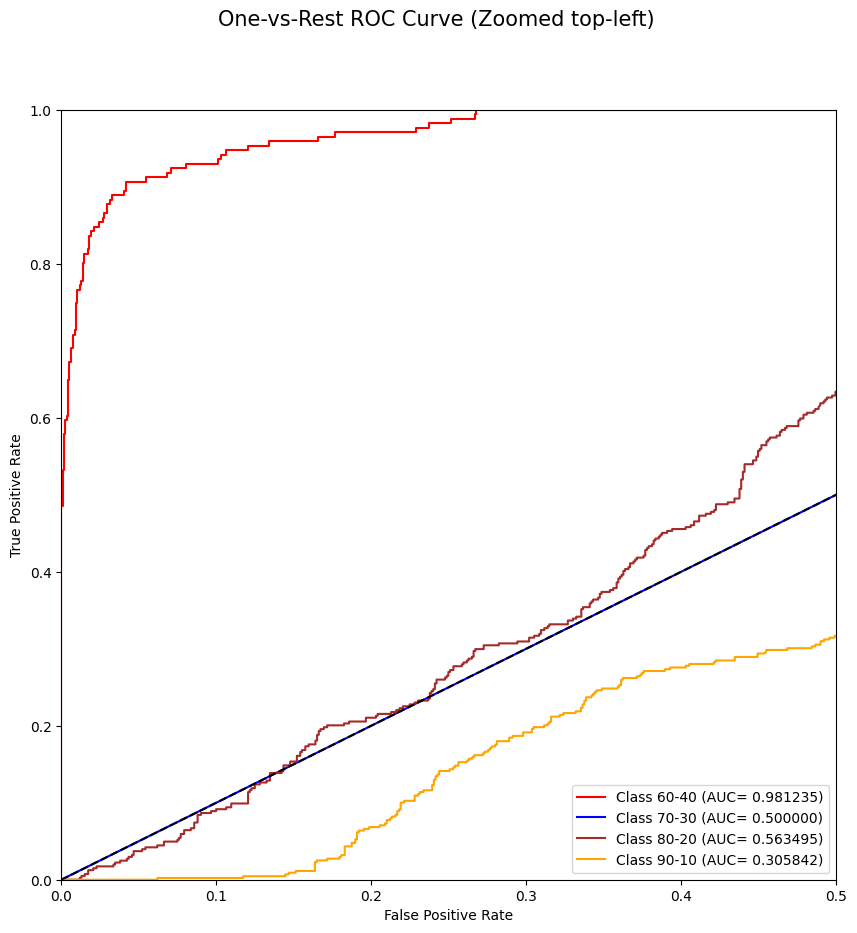

In [171]:
#Plotting the ROC Curve (Zoomed in at the top left corner)


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange']
for i in range(4):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 0.50])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve (Zoomed top-left)',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/EFFICIENTNETB0/EFFICIENTNETB0_ROC_AUC_Zoomed.eps', format='eps', dpi=600)
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/EFFICIENTNETB0/EFFICIENTNETB0_ROC_AUC_Zoomed.png', format='png', dpi=600)

In [172]:
#Calculating the Log-loss Score (One-vs-Rest)


temp=[0]*4
loss=[0]*4
epsilon = 1e-15  # Small constant to avoid division by zero
N = Binarized_True_label.shape[0]

for i in range(4):
  # Clip predicted probabilities to avoid log(0) cases
  temp[i]= np.clip(Predicted_probabilities[:,i], epsilon, 1 - epsilon)
  # Calculate cross-entropy loss
  loss[i] = -np.sum(Binarized_True_label[:,i] * np.log(temp[i])) / N

In [173]:
log_loss_result=[]
for i in range(4):
  log_loss_result.append([CLASSES[i],loss[i]])

In [174]:
column_headers=['CLASS','LOG-LOSS VALUE']
print('Log-Loss Results')
print(tabulate(log_loss_result, headers=column_headers, tablefmt="grid"))

Log-Loss Results
+---------+------------------+
| CLASS   |   LOG-LOSS VALUE |
+=========+==================+
| 60-40   |      0.000299208 |
+---------+------------------+
| 70-30   |     -0           |
+---------+------------------+
| 80-20   |      5.28416     |
+---------+------------------+
| 90-10   |     11.4434      |
+---------+------------------+


In [175]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}, F Score: {f_score}, Cohen Kappa Score: {kappa}')

Precision: 0.8709433674812317, Recall: 1.0, Accuracy: 0.2347169816493988, F Score: 0.9310205860483313, Cohen Kappa Score: 0.0


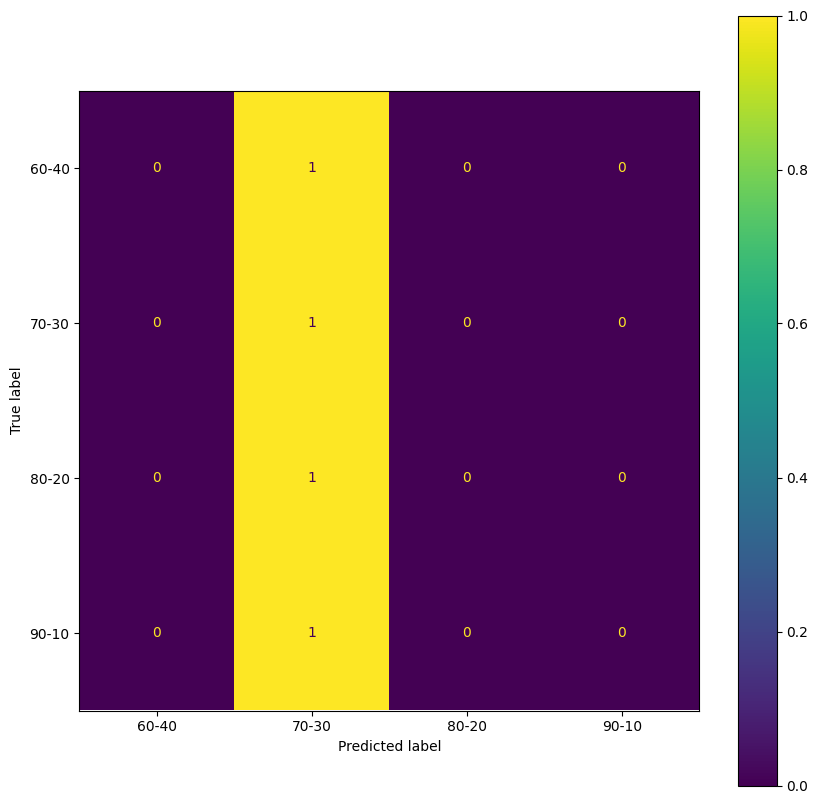

In [176]:
#Plotting the Confusion Matrix


confusion_matrix=metrics.confusion_matrix(True_label,Predicted_label,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["60-40","70-30","80-20","90-10"])
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.show()
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/EFFICIENTNETB0/EFFICIENTNETB0_Confusion_Matrix.eps', format='eps', dpi=600)
fig.savefig('/content/drive/MyDrive/Conference_Journal/2023_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/EFFICIENTNETB0/EFFICIENTNETB0_Confusion_Matrix.png', format='png', dpi=600)